In [26]:
import glob
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from main2 import data_transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load the saved model

In [86]:
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)
model = model.to(device)
model.load_state_dict(torch.load('ct_model.pt'))

<All keys matched successfully>

## Load some example images using PIL

In [87]:
PIL_images = []
filenames = []

labels = ["2_2", "3_4", "4_4"]
rand_labels = [labels[n] for n in np.random.randint(0, 3, 20)]

imagePaths = {
    "2_2": glob.glob("data/val/2_2/*.png"),
    "3_4": glob.glob("data/val/3_4/*.png"),
    "4_4": glob.glob("data/val/4_4/*.png")
}

for i in range(len(rand_labels)):
    label = rand_labels[i]
    imagePathSet = imagePaths[label]

    setInd = int(np.random.random() * len(imagePathSet))

    im = Image.open(imagePathSet[setInd])
    PIL_images.append(im)
    image_labels.append(label)
    filenames.append(imagePathSet[setInd])

### Use the validation image transformer.

In [88]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array([0.5, 0.5, 0.5]) + np.array([0.5, 0.5, 0.5])
    image = image.clip(0, 1)
    return image

for im in PIL_images:
    im = data_transforms['val'](im)
    im = im_convert(im)

## Use model to make predictions

In [91]:
predictions = []
for im in tensor_images:
    image = im.to(device).unsqueeze(0)
    output = model(image)
    _, pred = torch.max(output, 1)
    predictions.append(pred.item())

In [92]:
predictions

[0, 0, 1, 2, 2, 1, 0, 1, 2, 2, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1]

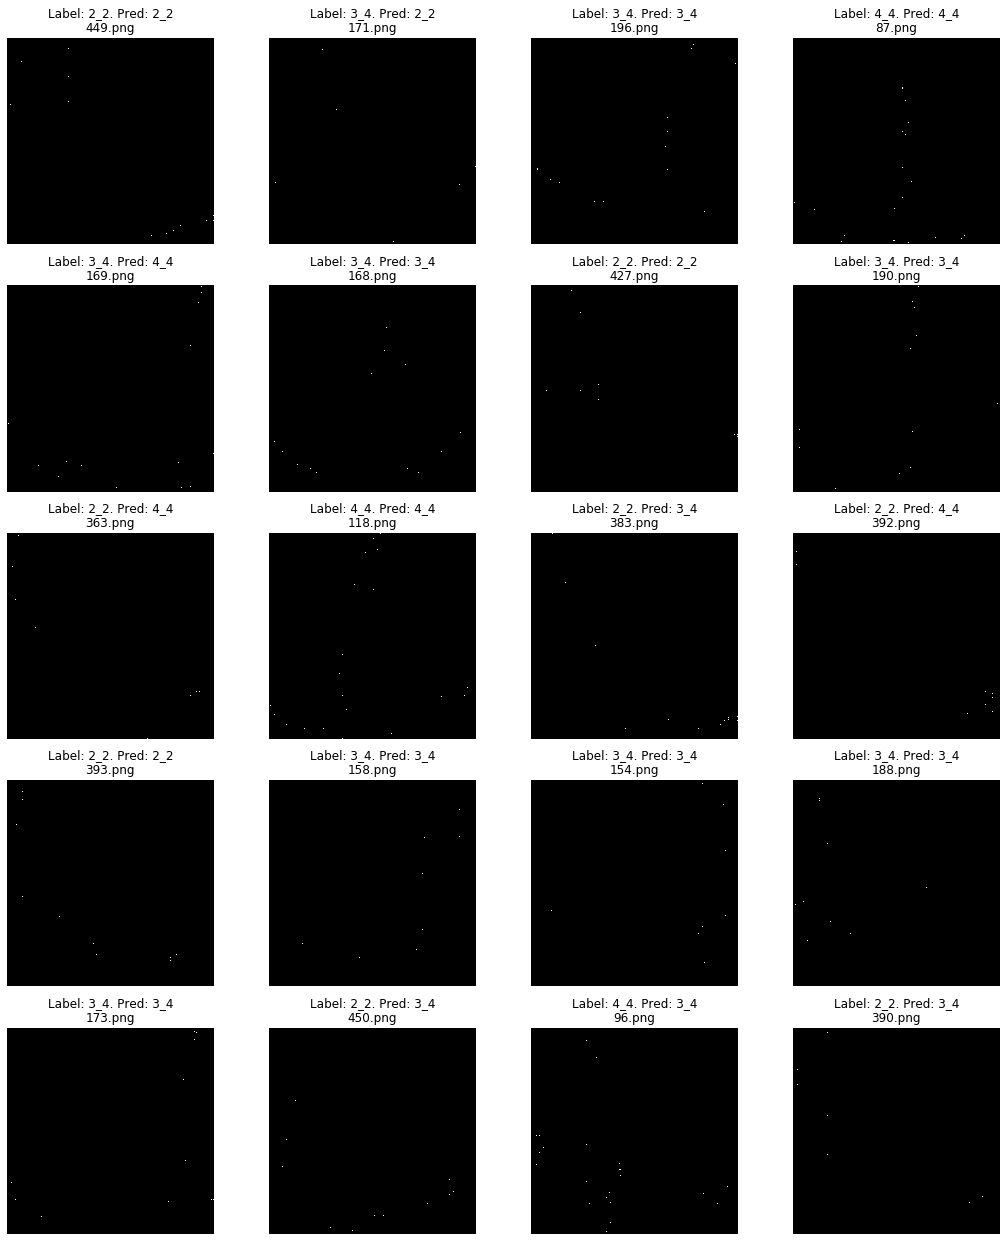

In [93]:
plt.figure(figsize=(18, 22))
for i in range(len(PIL_images)):
    plt.subplot(5, 4, i+1)
    plt.imshow(PIL_images[i])
    plt.axis("off")
    plt.title("Label: " + rand_labels[i] + ". Pred: " + str(labels[predictions[i]]) + "\n" + filenames[i].split('_')[-1])